In [3]:
# !pip install --no-cache-dir git+https://github.com/averinpa/bnm.git

In [1]:
from bnm import BNMetrics, generate_random_dag, dag_to_cpdag, compare_models_descriptive, compare_models_comparative, analyse_mb, generate_synthetic_data_from_dag
import networkx as nx
import pandas as pd
import numpy as np
from castle.algorithms import PC
import plotly.io as pio
pio.renderers.default = 'jupyterlab' 

2025-04-21 16:18:58,250 - C:\Users\averi\anaconda3\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-04-21 16:18:58,362 - C:\Users\averi\anaconda3\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


## Multiple Model Comparison: Motivation and Setup

Let’s assume we want to compare several outputs from structure learning algorithms.  
This scenario commonly arises in tasks such as algorithm selection, hyperparameter tuning, or assessing model stability under varying conditions.

By comparing multiple learned DAGs, we can investigate:

- **Algorithm Behavior**: How consistent are the outputs of a given algorithm across different runs?  
- **Model Stability**: Do changes in the data, for example, different transformations or normalization applied, lead to changes in algorithm outputs?  
- **Complexity Patterns**: Are certain algorithms more likely to produce dense or sparse graphs?  
- **Similarity Patterns**: How similar are the DAGs produced by different algorithms or under different setups?
  
By analyzing trends in descriptive and comparison metrics across models, we can get an indirect indication of which methods are more robust and better suited for specific domains or datasets.

This type of analysis is especially useful when no ground-truth DAG is available, as it helps in selecting structure learning methods by looking at indirect indications of output complexity and the stability of algorithms under different setups.



### Data Generation

To illustrate this use case, I am going to generate a random DAG with 40 nodes and edge probability of 10% using the `generate_random_dag` function. Then I generate synthetic data with the `generate_synthetic_data_from_dag` function, and then fit several algorithms to the data.  

For demonstration purposes, I will use the PC algorithm from the `gCastle` package and create 20 models with different alpha parameters.

In [2]:
true_dag = generate_random_dag(n_nodes=40, edge_prob=0.1, seed=55)
data = generate_synthetic_data_from_dag(true_dag, n_samples=1000, stdev=1.0, seed=55)
data = data[list(true_dag.nodes)]

## Structure learning

I will generate 20 alpha values ranging from 0.01 to 0.2 and store them in a list.  
Then, I will iteratively fit 20 models to the generated data, with each model using a different alpha value from the list.  
The outputs of the models will be stored as a list of adjacency matrices.


In [3]:
alphas = np.linspace(0.01, 0.2, 20)
list_of_models = list()
for i in alphas:
    pc = PC(variant='stable', alpha=i)
    pc.learn(data)
    learned_dag = pc._causal_matrix
    list_of_models.append(np.array(learned_dag))

Below, we will explore:  
- Complexity patterns and algorithm behavior  
- Similarity patterns and model stability


### Complexity patterns and algorithm behavior

The `compare_models_descriptive` function allows us to visualize descriptive metrics across a list of models, both for the global structure and for specific local structures of interest.

This function takes the following parameters:  
- A list of models  
- A list of model names  
- A list of node names  
- A list of Markov blankets to explore, in addition to the default full structure

Below is the output of the function for the full structure and the nodes `X_1`, `X_2`, and `X_3`.


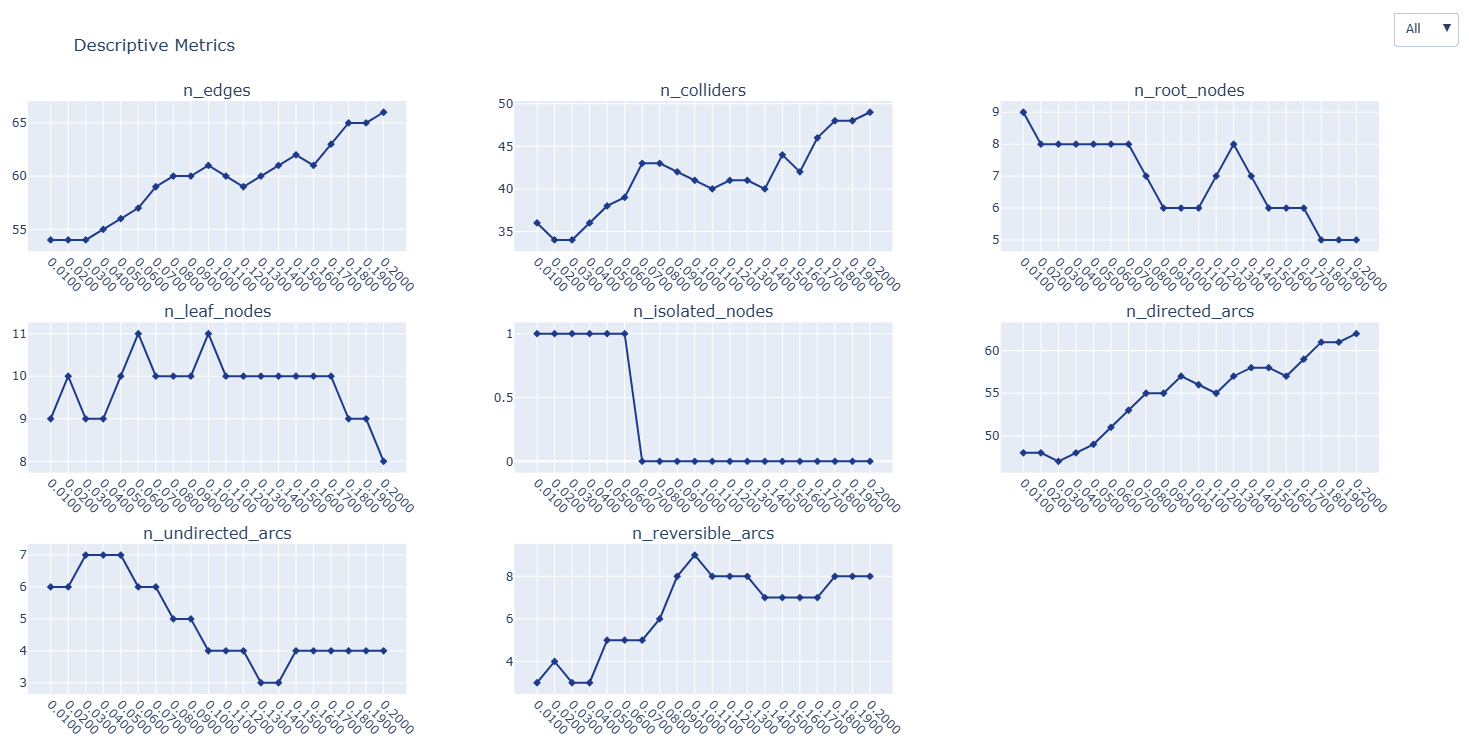

In [4]:
compare_models_descriptive(list_of_dags=list_of_models, model_names=alphas, node_names=list(true_dag.nodes), mb_nodes=['X_1', 'X_2', 'X_3'])

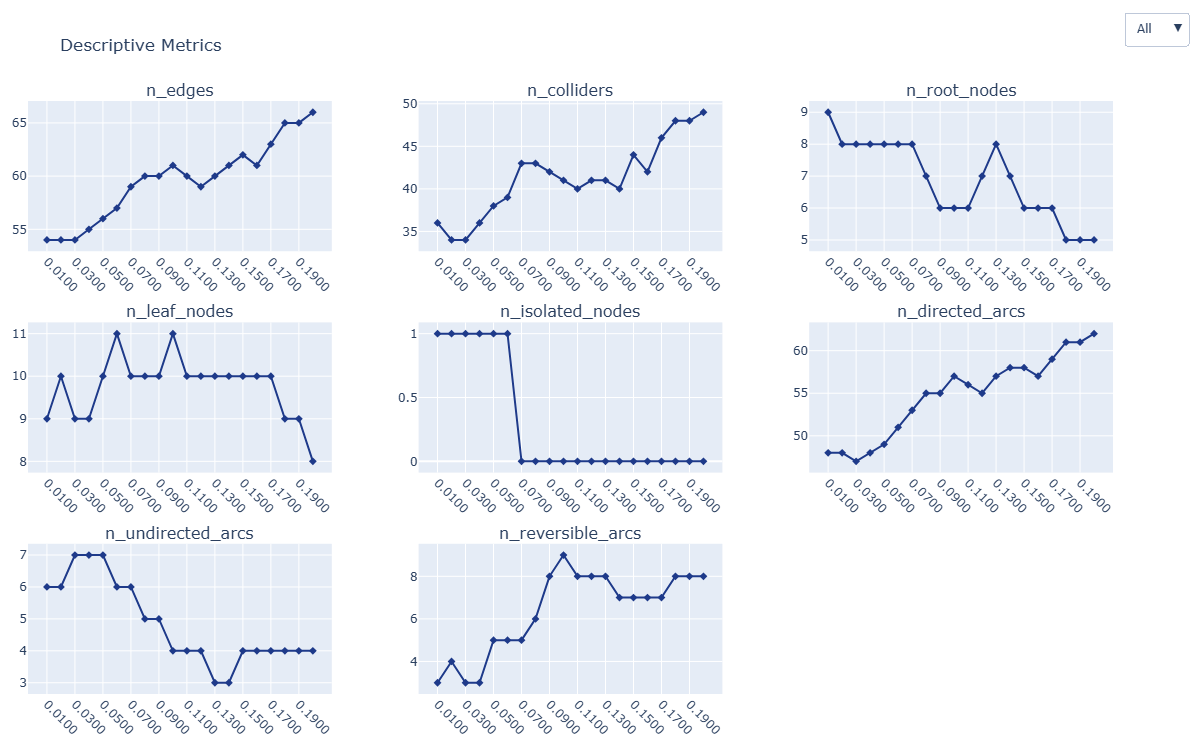

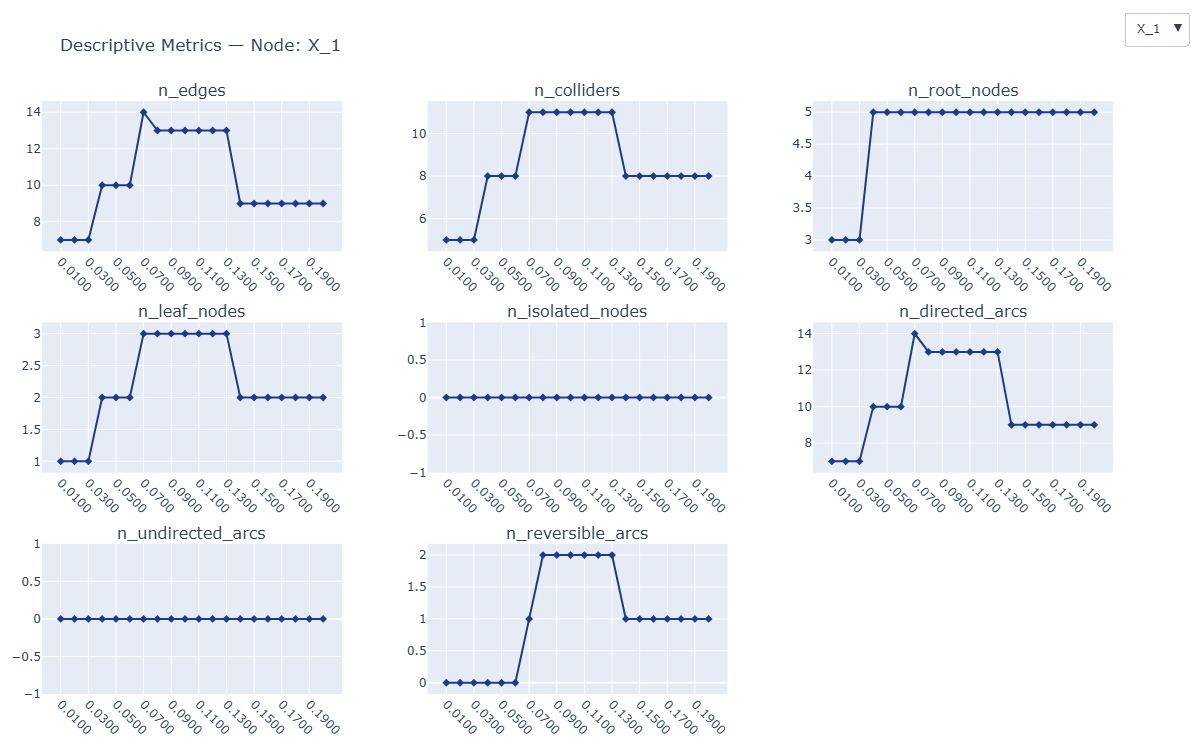

As expected, when the alpha value is higher, the resulting network is more complex.  
This is because constraint-based algorithms (such as the PC algorithm) rely on conditional independence tests to determine whether an edge should be present between two nodes.

The alpha parameter controls the significance level of these statistical tests.

- When the alpha value is higher, the test becomes less strict, meaning it is more likely to detect a dependency and retain an edge.  
- When the alpha value is lower, the test becomes more conservative, meaning it is more likely to declare variables as conditionally independent and remove edges.

So, as alpha increases, more edges tend to be included in the graph, resulting in greater complexity.  
Conversely, lower alpha values typically lead to sparser networks.

This aligns with what we observe in the results: larger alpha values produce denser graphs due to the algorithm being more permissive in detecting dependencies.  
This is traceable in metrics such as number of edges, number of colliders and number of isolated nodes.

When we look at the Markov blanket of node `X_1`, for example (you can navigate using the dropdown), the picture is not entirely clear.  
If we look at the number of edges, at alpha 0.07 there are 14 edges, but at alpha values of 0.14 and above, there are only 9 edges.

Let’s examine this more closely using plots.


In [5]:
bb = BNMetrics(list_of_models[6], list_of_models[13], node_names=list(true_dag.nodes), mb_nodes=['X_1'])
bb.compare_two_bn(nodes=['X_1'], name1=f'Markov blanket of node X_1 with alpha = {alphas[6]:.2f}', name2=f'Markov blanket of node X_1 with alpha = {alphas[13]:.2f}')

Indeed, from the visualization, we can see that for the Markov blanket of node `X_1`, lower values of alpha result in a higher number of edges.  
This is very interesting and somewhat counterintuitive. Additional analysis is required to better understand this phenomenon.

### Similarity Patterns and Model Stability

The `compare_models_comparative` function produces a heatmap representing the comparison of models with each other.  
The function takes the following arguments:  
- A list of models  
- A list of model names  
- A list of node names  
- A metric to analyze  
- A list of Markov blankets to explore, in addition to the default full structure

Below is the output of the function for the full structure and the nodes `X_1`, `X_2`, and `X_3`.  
We are focusing on the F1 score, which is the harmonic mean of precision and recall.


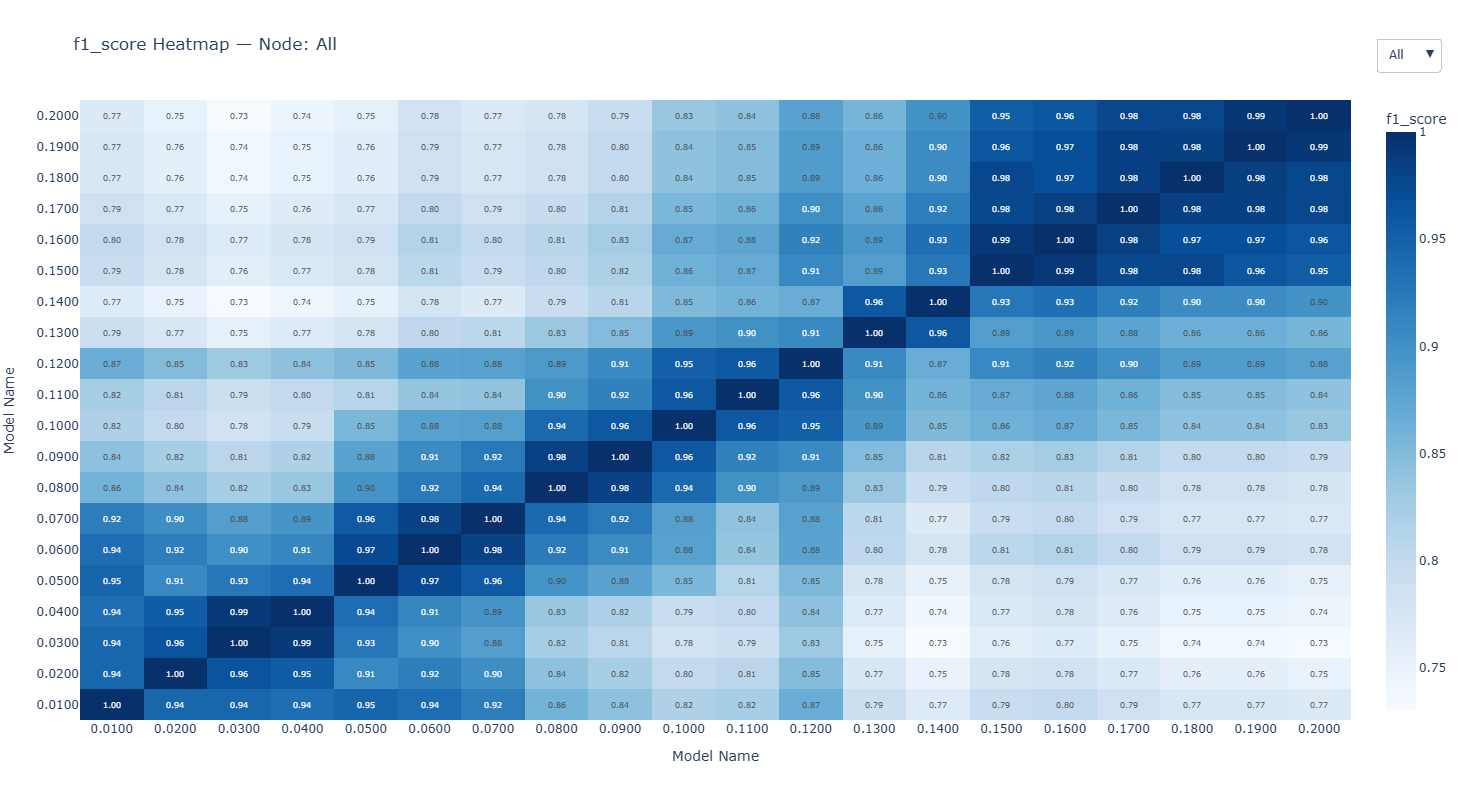

In [6]:
compare_models_comparative(list_of_dags=list_of_models, model_names=alphas, node_names=list(true_dag.nodes), metric='f1_score', mb_nodes=['X_1', 'X_2', 'X_3'])

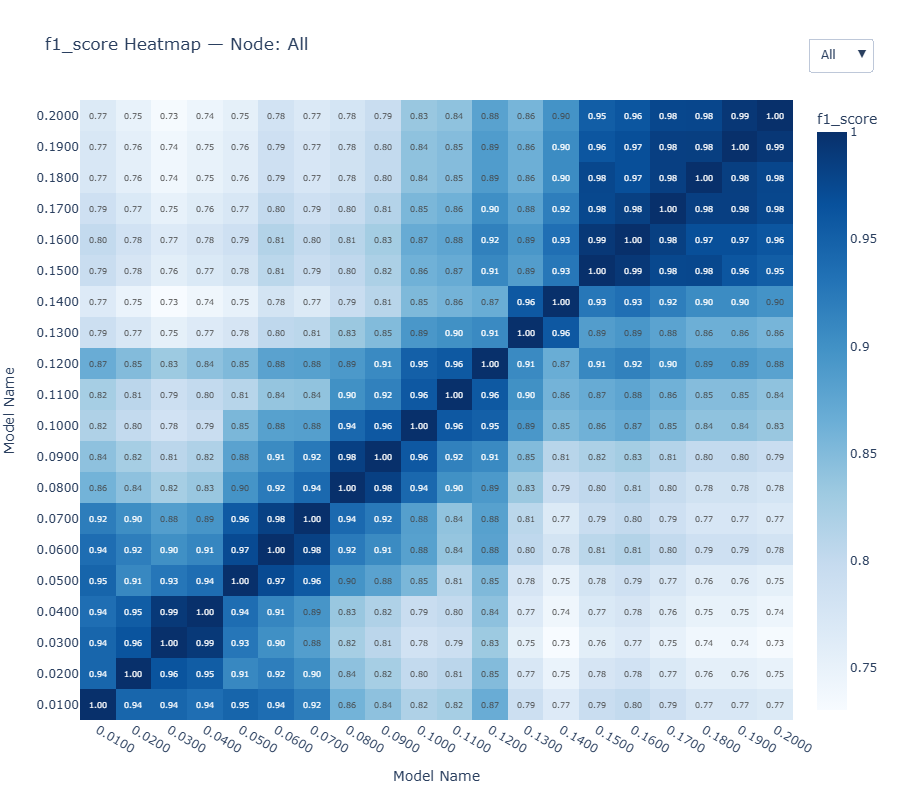

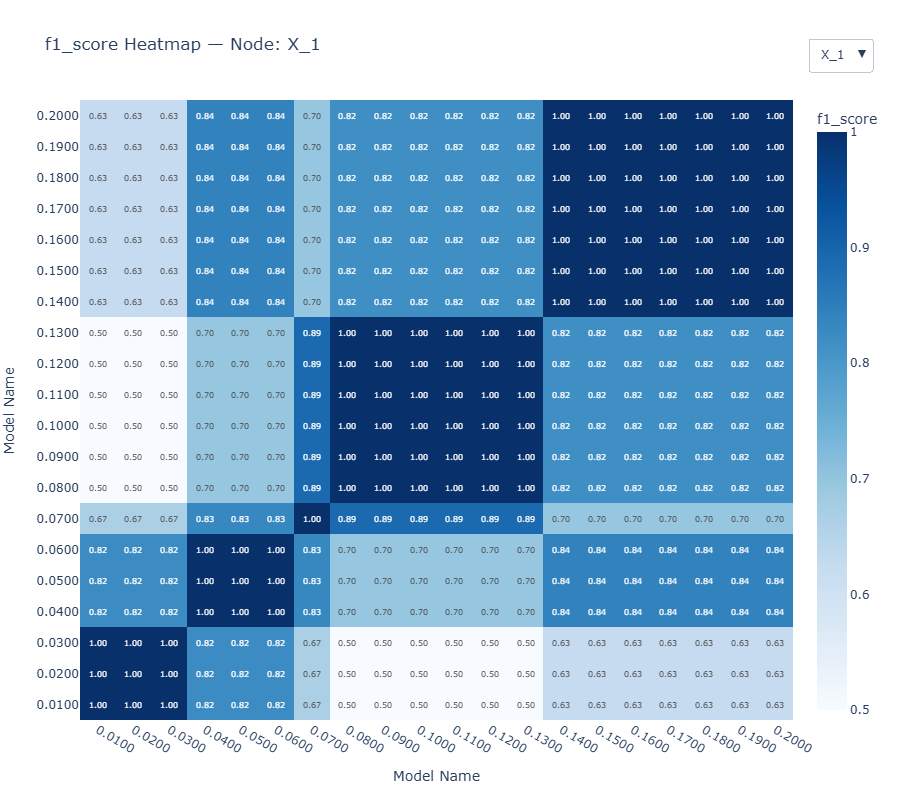

For the full structure, the F1 score ranges from 0.73 to 1.  
Some models are very similar — for example, the models with alpha values of 0.03 and 0.04, as well as those with 0.19 and 0.20, have an F1 score of 0.99.  
The least similar models are those with alpha values of 0.03 and 0.20, and 0.03 and 0.14.

We can also observe that the model with an alpha value of 0.12 has an F1 score above 0.83 when compared to all other models.  
This may serve as an indirect indicator of model stability.

If we zoom in on the Markov blanket of node `X_1`, we can see that several models produce exactly the same result — this is evident in the areas of the heatmap where the F1 score is 1.  

Some areas of the heatmap also highlight the least similar models — for example, models with alpha values between 0.01 and 0.03 compared to models with alpha values between 0.08 and 0.13.

We can now inspect the most similar models by visualizing the Markov blankets of node `X_1`.
 

In [7]:
bb = BNMetrics(list_of_models[7], list_of_models[12], node_names=list(true_dag.nodes), mb_nodes=['X_1'])
bb.compare_two_bn(nodes=['X_1'], name1=f'Markov blanket of node X_1 with alpha = {alphas[7]:.2f}', name2=f'Markov blanket of node X_1 with alpha = {alphas[12]:.2f}')

From the plot above, we can see that for the Markov blanket of node `X_1`, all edges are shown in red, indicating that the Markov blankets are identical.  

Now, let's look at the least similar Markov blankets of node `X_1`.


In [8]:
bb = BNMetrics(list_of_models[0], list_of_models[12], node_names=list(true_dag.nodes), mb_nodes=['X_1'])
bb.compare_two_bn(nodes=['X_1'], name1=f'Markov blanket of node X_1 with alpha = {alphas[0]:.2f}', name2=f'Markov blanket of node X_1 with alpha = {alphas[12]:.2f}')

From the plot above, we can see that the model with an alpha value of 0.01 produced a Markov blanket for node `X_1` that is very dissimilar compared to the model with an alpha value of 0.13.  

These are interesting insights obtained through the use of the `bnm` package.


## Conclusion

In this notebook, we explored how the `bnm` package can be used to compare multiple models generated by a structure learning algorithm under different hyperparameter settings.  
By varying the alpha value in the PC algorithm and analyzing the resulting DAGs, we were able to assess both global and local structural patterns.

We observed that:
- Higher alpha values generally lead to more complex networks, though this trend can vary locally (as seen in the Markov blanket of node `X_1`).
- Similarity analysis using F1 scores revealed which models produce consistent structures, and which differ substantially.
- Visual inspection of Markov blankets provided insights into model behavior, identifying both stable and unstable parametrizations.

These results demonstrate the importance of evaluating model stability when no ground-truth DAG is available.  
The `bnm` package facilitates this process by of evaluating model stability and complexity combining descriptive and comparative metrics with intuitive visualizations.
